# SerWisS Analyse

Zuerst werden die Metadaten von SerWisS via OAI-PMH mit Sickle abgefragt. Ein Dataframe wird erstellt, mit dem dann in der Folge gearbeitet werden kann. Kommentare zum genauen ABlauf im Code. 

In [2]:
import pandas as pd
from sickle import Sickle
from lxml import etree
import matplotlib.pyplot as plt

# OAI-PMH-Endpoint
endpoint = 'https://serwiss.bib.hs-hannover.de/oai'

# Sickle initialisieren
sickle = Sickle(endpoint)

# Liste für die Einträge 
records = sickle.ListRecords(metadataPrefix='oai_dc')

data = []

# Namespace für Dublin Core
ns = {'dc': 'http://purl.org/dc/elements/1.1/'}

# Schleife für die Einträge
for record in records:
    # Deleted überspringen
    if record.deleted:
        continue

    # XML parsen
    metadata = record.xml.find('.//{http://www.openarchives.org/OAI/2.0/}metadata')

    # Falls leer, zum nächsten springen
    if metadata is None:
        continue

    # Metadaten extrahieren, hier weitere Felder ergänzen
    record_id = metadata.find('.//dc:identifier', namespaces=ns)
    title = metadata.find('.//dc:title', namespaces=ns)
    date = metadata.find('.//dc:date', namespaces=ns)
    formats = metadata.findall('.//dc:format', namespaces=ns)
    authors = metadata.findall('.//dc:creator', namespaces=ns)
    subjects = metadata.findall('.//dc:subject', namespaces=ns)
    language = metadata.findall('.//dc:language', namespaces=ns)

    # Felder als Dictionary der Liste "data" anhängen
    data.append({
        'ID': record_id.text if record_id is not None else None,
        'Title': title.text if title is not None else None,
        'Date': date.text if date is not None else None,
        'Format': ', '.join([f.text for f in formats if f is not None]),
        'Author/Creator': ', '.join([a.text for a in authors if a is not None]),
        'Subject/Keywords': ', '.join([s.text for s in subjects if s is not None]),
        'Language': ', '.join([l.text for l in language if l is not None])
    })

# Dataframe aus Liste erzeugen
df = pd.DataFrame(data)

# Kopf des df zu Prüfzwecken anzeigen
print(df.head())


                                                  ID  \
0  https://serwiss.bib.hs-hannover.de/frontdoor/i...   
1  https://serwiss.bib.hs-hannover.de/frontdoor/i...   
2  https://serwiss.bib.hs-hannover.de/frontdoor/i...   
3  https://serwiss.bib.hs-hannover.de/frontdoor/i...   
4  https://serwiss.bib.hs-hannover.de/frontdoor/i...   

                                               Title        Date  \
0  Teaching Information Literacy with the Lerninf...        2006   
1  Personalisiertes Lernen in der Bibliothek: das...        2006   
2  Informationseinrichtungen im Bereich Film : ei...  2008-03-04   
3           Wissensmanagement und Balanced Scorecard        2003   
4        Marketing strategies for academic libraries        2003   

            Format                        Author/Creator  \
0  application/pdf  Hauschke, Christian, Ullmann, Nadine   
1  application/pdf  Hauschke, Christian, Ullmann, Nadine   
2  application/pdf                    Brechmacher, Janna   
3  application

In [3]:
# Basisstatistiken für die Dokumente

# Gesamtanzahl der Einträge
total_records = len(df)

# Anzahl der Titel (unique)
unique_titles = df['Title'].nunique()

# Anzahl der Formate (unique)
unique_formats = df['Format'].nunique()

# Anzahl der  Autor:innen (unique)
unique_authors = df['Author/Creator'].nunique()

# Anzahl Doks/Jahr (aus der 'Date'-Spalte)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # 'Date' in datetime umwandeln, Fehler zu NaT umwandeln
records_per_year = df['Date'].dt.year.value_counts().sort_index()

# Anzahl der Sprachen (unique)
unique_languages = df['Language'].nunique()

# Statistiken ausgeben
print(f"Gesamtanzahl der Einträge: {total_records}")
print(f"Anzahl der einzigartigen Titel: {unique_titles}")
print(f"Anzahl der einzigartigen Formate: {unique_formats}")
print(f"Anzahl der einzigartigen Autoren/Ersteller: {unique_authors}")
print(f"Anzahl der einzigartigen Sprachen: {unique_languages}")
print("\nAnzahl der Einträge pro Jahr:")
print(records_per_year)


Gesamtanzahl der Einträge: 1415
Anzahl der einzigartigen Titel: 1404
Anzahl der einzigartigen Formate: 8
Anzahl der einzigartigen Autoren/Ersteller: 1033
Anzahl der einzigartigen Sprachen: 2

Anzahl der Einträge pro Jahr:
Date
1975.0      8
1976.0      5
1977.0      4
1978.0      1
1979.0      3
1980.0      5
1981.0      5
1983.0      3
1984.0      5
1985.0     10
1986.0     12
1987.0      9
1988.0     12
1989.0     13
1990.0     20
1991.0     12
1992.0     15
1993.0     19
1994.0     12
1995.0      4
1996.0      3
1997.0      2
1998.0      4
1999.0      5
2000.0      8
2001.0      9
2002.0     10
2003.0     17
2004.0      6
2005.0     13
2006.0     13
2007.0     16
2008.0     15
2009.0     19
2010.0     14
2011.0     11
2012.0     19
2013.0     25
2014.0     42
2015.0     30
2016.0     69
2017.0     63
2018.0     82
2019.0     76
2020.0     82
2021.0    116
2022.0    130
2023.0    128
2024.0     53
Name: count, dtype: int64


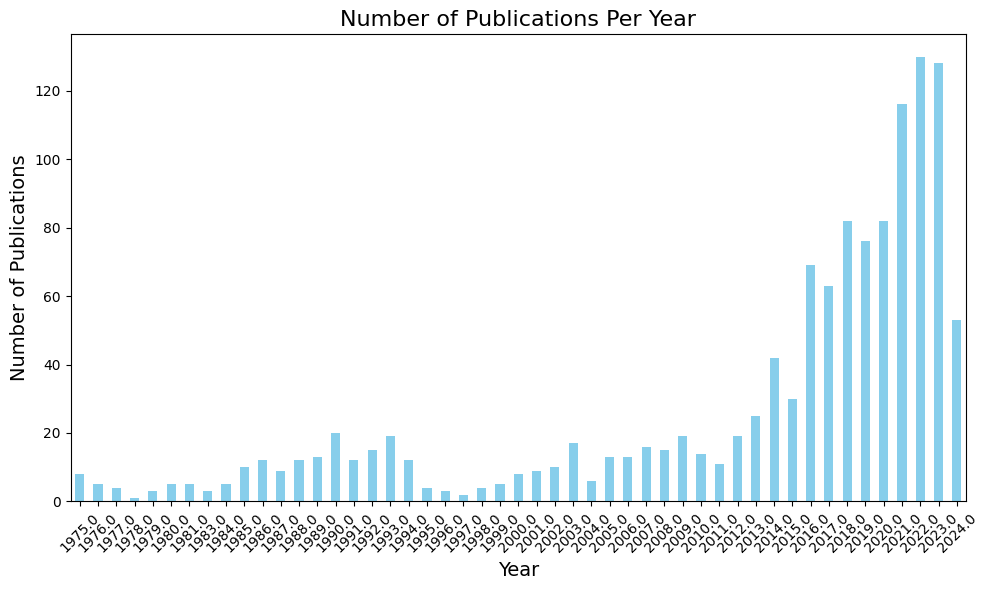

In [4]:

# Daten zu datetime konvertieren, Spalte "year" anlegen, gruppieren und zählen.
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df['Year'] = df['Date'].dt.year

publications_per_year = df.groupby('Year').size()

publications_per_year = publications_per_year.dropna()

# Plot generieren
plt.figure(figsize=(10,6))
publications_per_year.plot(kind='bar', color='skyblue')

# Beschriftung
plt.title('Number of Publications Per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Publications', fontsize=14)

# Plot anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


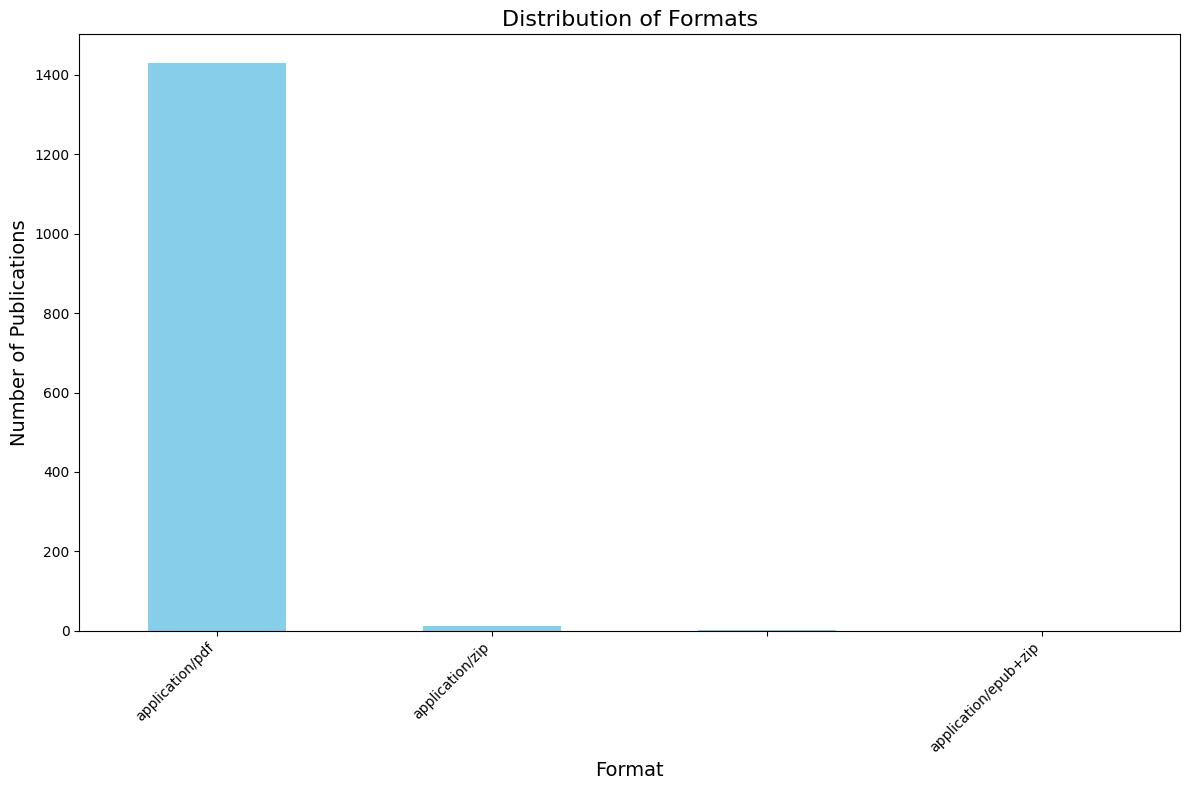

In [5]:
# Split the 'Format' column into multiple rows if it contains multiple formats
df['Format'] = df['Format'].fillna('')  # Replace NaN with empty string
formats = df['Format'].str.split(', ', expand=True).stack()

# Count occurrences of each format
format_counts = formats.value_counts()

# Plot the bar chart
plt.figure(figsize=(12, 8))
format_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Distribution of Formats', fontsize=16)
plt.xlabel('Format', fontsize=14)
plt.ylabel('Number of Publications', fontsize=14)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [6]:
# NaN-Werte in 'Format' ersetzen
df['Format'] = df['Format'].fillna('')

# 'Format' in mehrere Zeilen aufteilen, falls mehrere Formate enthalten
formats = df['Format'].str.split(', ', expand=True).stack()

# df mit einzelnen Formaten erstellen
formats_df = formats.reset_index(level=0, drop=True).to_frame(name='Format')

# Vorkommen der Formate pro ursprünglicher Zeile zählen
formats_count = formats_df.groupby(formats_df.index).Format.apply(lambda x: ', '.join(set(x)))

# Count zurück ins ursprüngliche df
df['Format'] = formats_count


# 'Format' in string umwandeln
df['Format'] = df['Format'].astype(str)

# Filter: nur 'application/pdf' und 'nan'
df_filtered = df[df['Format'].apply(lambda x: set(x.split(', ')) != {'application/pdf'})]
df_filtered = df[df['Format'].apply(lambda x: set(x.split(', ')) != {'nan'})]

# Relevante Spalten auswählen
df_filtered = df_filtered[['Title', 'Format', 'ID']]

# Gefiltertes DataFrame anzeigen
df_filtered.reset_index(drop=True, inplace=True)  # Index für bessere Anzeige zurücksetzen
df_filtered


,Title,Format,ID
0,Teaching Information Literacy with the Lerninf...,", application/zip, application/pdf",https://serwiss.bib.hs-hannover.de/frontdoor/i...
1,Personalisiertes Lernen in der Bibliothek: das...,"application/zip, application/pdf, application/...",https://serwiss.bib.hs-hannover.de/frontdoor/i...
2,Informationseinrichtungen im Bereich Film : ei...,"application/zip, application/pdf",https://serwiss.bib.hs-hannover.de/frontdoor/i...
3,Wissensmanagement und Balanced Scorecard,application/zip,https://serwiss.bib.hs-hannover.de/frontdoor/i...
4,Marketing strategies for academic libraries,application/zip,https://serwiss.bib.hs-hannover.de/frontdoor/i...
5,Libworld. Biblioblogs global,application/pdf,https://serwiss.bib.hs-hannover.de/frontdoor/i...
